<a href="https://colab.research.google.com/github/huskeypm/cellmigration/blob/main/expt_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exptl analysis
Last ran on colab, 240311

This notebook
* loads tif files from a migration experiment,
* uses trackpy to find moving cells, and
* fits a linear equation to their mean square displacements to obtain a diffusion coefficient.

Data
* My input data is currently located at
/content/drive/MyDrive/public/
which is mounted to google drive.
* This path will need to be adjusted if data are stored elsewhere

Usage:
* Copy files of interest to an appropriate google drive directory
(current set is from Emily's Feb collections)
* run the first part of the code to completion and **modify the default parameters** to work with your data
* once the right parameters are determined, process your remaining files; a csv file should result for each input file

To analyze
* Use second part of notebook to load in csv files and plot

Install needed packages



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip3 install pims trackpy

Check out cellmigration github repo

In [13]:
!git clone https://github.com/huskeypm/cellmigration.git
#!cd cellmigration; git pull

fatal: destination path 'cellmigration' already exists and is not an empty directory.


In [14]:
import sys
sys.path.append("cellmigration")

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import pims
import trackpy as tp
import tifffile

import expt_analysis.trackcells as tc

# Process raw images
## Image processing

Define inputs (pretty much the only places needed for making changes)

In [16]:
!ls /content/cellmigration

ls: cannot access '/content/cellmigration': No such file or directory


In [44]:
# read in image and show first frame
user = "Emily"
#user = "PKH"
useGdrive = False
if user == "Emily":
  name='1'
  path="/home/ekrueger2/microscopy_data/022624"
  fileName=path+"/Capture1-Position{}_XY1708990389_Z0_T000_C0.tif".format(name)
    #fileName=r"C:\Users\ekrue\Downloads\12_13_23_{}.tif".format(name)
elif user == "PKH":
  name = "Position_1" #
  #name = "Position_3"
  gpath=('/content/drive')
  path=gpath+"/MyDrive/public/"
  fileName = path+"/%s_movie.tif"%name
  useGdrive=True
  sourcePath = "/content/cellmigration/"
#
#  Parameters to edit
#
# time/frame conversion
fr = 180 # s/fr # experiment

# image processing parameters (disable downsample and crop for full analyses )
downsampleRate = 10
#crop=[[300,900],[300,900]]
crop=[[300,600],[500,800]]

thresh=105


# determine parameters to track particles
# paramters: diameter, minmass
#- positiion 1
#iameter=101 # adjust me first
#inmass = 75000
#- positiion 2
#diameter=91  # adjust me first
#minmass = 100
#- positiion 3
#diameter=101  # adjust me first
#minmass = 1000
#cropped position 1 values
diameter=21
minmass=15000

# for fitting MSDs
fittingRange=[0,100]



Read images

Mount google drive.
I added a shortcut to a shared tif file in my 'public' directory

 /content/drive/MyDrive/public/

In [45]:
if useGdrive:
  from google.colab import drive
  drive.mount(gpath)

(480, 992, 992)


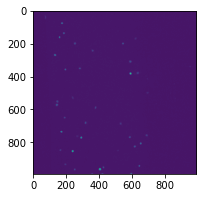

In [46]:
# read image
raw_data = tifffile.imread(fileName)
print(raw_data.shape)

multiChannel = False
if multiChannel:
  channel=0
  frames=raw_data[:,channel,:,:]
else:
  frames=raw_data[:,:,:]

plt.imshow(frames[0,:,:])


(48, 300, 300)
0


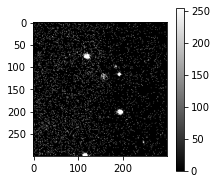

In [47]:

thresh=105
threshed = tc.ProcessFrames(frames,
                            downsampleRate=downsampleRate,
                            crop=crop,thresh=thresh)



print(np.min(threshed[0,:]))


### Tracking

* If cells aren't detecting, reduce diameter/minmass or both.
* The displayed mass histogram can help with this optimization

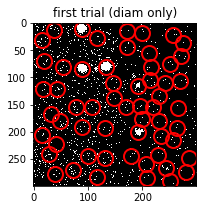

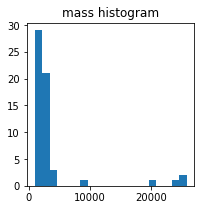

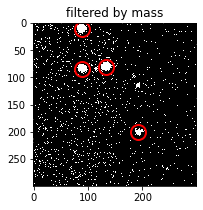

In [48]:

dummy = tc.TrialParams(threshed,refFrame=0,diameter=diameter,minmass=minmass)
if dummy.shape[0] <1:
  print("Error finding cells; try different parameters")
else:
  finalStack = threshed


In [49]:
# run batch/tracking
fb=tc.DoTracking(finalStack,diameter=diameter,minmass=minmass)

try:
  print("shape final %d"%fb.shape[0])
except:
  print("Unsuccessful tracking")

fb

Frame 47: 2 features
shape final 151


,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,11.281553,88.598424,25794.265735,6.065329,0.052714,137.170908,62730.0,0.0,0
1,83.746480,89.900043,25315.460620,5.742770,0.044865,141.961383,57885.0,0.0,0
2,80.685543,133.796107,24473.333029,5.861512,0.004067,129.495525,60945.0,0.0,0
3,200.212613,192.804297,19984.313057,4.981532,0.205454,173.937718,39525.0,0.0,0
4,12.143454,87.614643,24984.732825,5.855057,0.096911,145.300062,58905.0,0.0,1
...,...,...,...,...,...,...,...,...,...
146,67.401187,132.593433,16982.881648,4.626693,0.077203,168.545308,36210.0,0.0,46
147,200.843693,193.341671,17426.344722,4.673700,0.213649,181.109613,32640.0,0.0,46
148,259.702802,86.109098,21362.920698,5.305608,0.302545,164.736431,43350.0,0.0,46
149,76.068738,120.258748,18246.536671,4.711442,0.117248,161.573645,39525.0,0.0,47


### MSD analyses

<font color=red>WARNING: the msd plot needs to be rescaled according to correct spatial and temporal units</font>

Frame 47: 2 trajectories present.
Found 151 
Retained 140 particles
Drift 
                y          x
frame                      
1     -10.575460  -1.350112
2      -1.227148   0.683659
3       6.029416   0.349898
4      -3.221743  -0.077377
5     -13.613540   4.343225
6     -11.877320   8.302743
7      -0.901832   4.706375
8      -4.772590   3.894105
9      -8.992487   1.820584
10     -6.300074   1.556845
11      0.046719   0.875711
12      6.165522   0.672141
13      3.485385   6.150665
14     -5.396930   1.672480
15     -5.888780   6.822788
16      5.594959   9.193945
17      9.726081   8.794066
18     19.218344   9.698050
19     12.316952  10.838089
20      1.273190   5.507603
21     15.121712   6.603819
22     19.420451   8.513538
23     34.733852   9.500577
24     49.100127   2.215442
25     38.188938  -0.668043
26     36.428275 -12.474265
27     35.872376 -11.460779
28     29.949390 -14.203742
29     30.624909 -15.067271
30     32.895523 -13.370214
31     32.569493 -14.654144


/home/ekrueger2/anaconda3/lib/python3.9/site-packages/trackpy/motion.py:235: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = msds.mul(msds['N'], axis=0).mean(level=1)  # weighted average
/home/ekrueger2/anaconda3/lib/python3.9/site-packages/trackpy/motion.py:236: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = results.div(msds['N'].mean(level=1), axis=0)  # weights normalized


<Figure size 360x216 with 0 Axes>

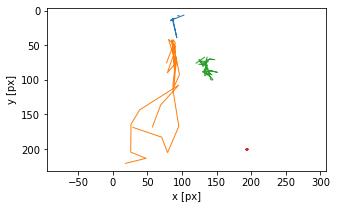

Double check, data contains ALL particle trajectories? (%d)


<Figure size 360x216 with 0 Axes>

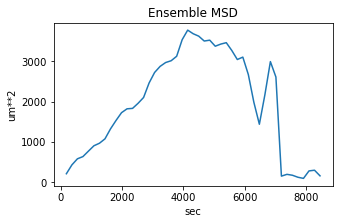

In [51]:
# compute MSD
ts,traj,msd,im,em=tc.DoMSD(
    fb,
    maxDist=80, # maximum displacement between frames in pixel
    maxMissFrame=10, # allowed number of frames a particle can disappear
    minFrame=10, # minimum number of frames a trajectory needs to last
    pixelSize=1.1, # image pixel size in micron/pixel, specific for each scope and lens (Cytiva 10X: 0.65) and (Spinning Disk: 1.1 at 10X)
    frameRate=1/fr, # image acquisition rate in frames/sec
    max_lagtime=160, # intervals of frames out to which MSD is computed
    name=name
)


slope/intercept [5.26369878e-04 1.94643879e+03]


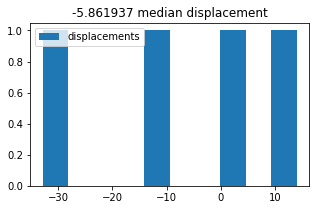

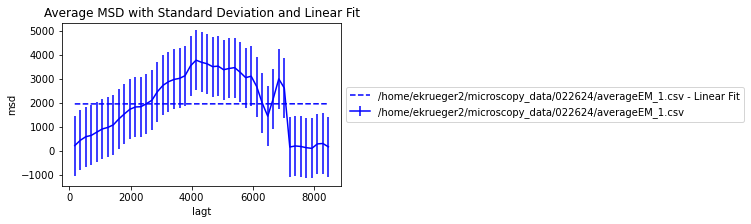

In [52]:



# get displacements
dists, xdists = tc.CalcDistances(traj) # performed on trajectories BEFORE drift-correction
med = np.median(xdists)
plt.figure()
plt.title("%f median displacement"%med)
plt.hist(xdists,label="displacements")
plt.legend(loc=0)

# save average MSD for each run to csv file
msdFileName=path+'/averageEM_{}.csv'.format(name)
diffFileName=path+'/diff_{}.csv'.format(name)
if name is not None:
    em.to_csv(msdFileName)
    np.savetxt(diffFileName,np.array(xdists))
    # prompt: save pandas dataframe
    traj.to_csv(path+'/traj_{}.csv'.format(name))
    fb.to_csv(path+'/fbframe_{}.csv'.format(name))

msdFile={
    path+'/averageEM_{}.csv'.format(name):{"color":"blue"}
}
plt.figure()
tc.doMSDFit(msdFile, fittingRange=fittingRange)

#individual MSDs? save figures?

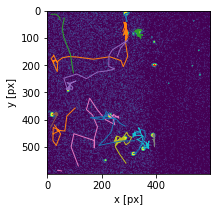

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [27]:
plt.figure()
plt.imshow(threshed[0,:,:])
tp.plot_traj(traj)

# Post processing

Create list of names

In [40]:
path

'/home/ekrueger2/microscopy_data/022824'

slope/intercept [  2.13669037 638.39398653]


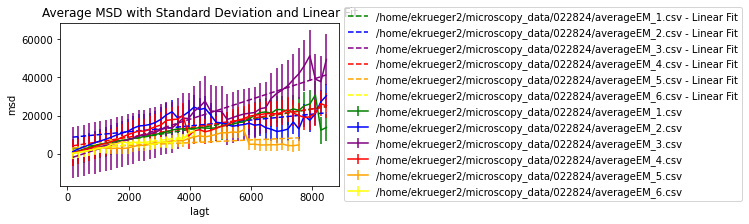

In [90]:
# import average MSD csv files and plot with Std and linear fit

average_MSD_files={
    'averageEM_Position1.csv':{"color": "blue"},
    'averageEM_Position2.csv':{"color": "purple"},
    'averageEM_Position3.csv':{"color": "red"},
    'averageEM_Position4.csv':{"color": "orange"},
    'averageEM_Position5.csv':{"color": "yellow"},
    'averageEM_Position6.csv':{"color": "green"}
    }
average_MSD_files={
    path+'/averageEM_1.csv':{"color": "green"},
    path+'/averageEM_2.csv':{"color": "blue"},
    path+'/averageEM_3.csv':{"color": "purple"},
    path+'/averageEM_4.csv':{"color": "red"},
    path+'/averageEM_5.csv':{"color": "orange"},
    path+'/averageEM_6.csv':{"color": "yellow"},
}


fittingRange=[0,100]
tc.doMSDFit(average_MSD_files, fittingRange=fittingRange)



<font color=red>NEED TO EDIT ONCE I HAVE THE low/high ATP JOBS </font>


### No ATP

Not sure how this naming scheme was decided upon

In [39]:
# former path
filenames_confinement = []
filenames_confinement.append(
    path+'/averageEM_Position_1.csv'
    )
diff_filenames = []
diff_filenames.append(
    path+'/diff_Position_1.csv'
    )
caseNames = ["-ATP" for x in range(len(filenames_confinement))]


### With ATP

In [40]:
# with atp?
filenames_confinement_ATP = []
filenames_confinement_ATP.append(
    path+'/averageEM_Position_2.csv'
    )
diff_filenames_ATP = []
diff_filenames_ATP.append(
    path+'/diff_Position_2.csv'
    )

caseNamesATP = ["+ATP" for x in range(len(filenames_confinement_ATP))]
#print(casesATP)

In [41]:
filenames_confinement =  filenames_confinement + filenames_confinement_ATP
diff_filenames =  diff_filenames + diff_filenames_ATP
caseNames = caseNames + caseNamesATP

In [42]:
print(filenames_confinement)

['/content/drive/MyDrive/public//averageEM_Position_1.csv', '/content/drive/MyDrive/public//averageEM_Position_2.csv']


### Load data
We used to load/process images here, but now we just use postprocessed data here (tracking happens elsewhere in notebook)

In [43]:
cases = dict()
class empty:pass

In [52]:
for i,filename in enumerate(filenames_confinement):

    # store data
    case = empty()

    #
    case.name = filenames_confinement[i]
    ar = pd.read_csv(filenames_confinement[i])
    print("Lag time isn't quite what we want")
    case.time1 = ar['lagt']
    case.dataavg1 = ar['msd']
    print("D is needed")
    ar = pd.read_csv(filename)
#    case.D = D
    ar = pd.read_csv(diff_filenames[i])
    case.dists = ar

    cases[caseNames[i]] = case


Lag time isn't quite what we want
D is needed
Lag time isn't quite what we want
D is needed


Text(0, 0.5, 'Prob')

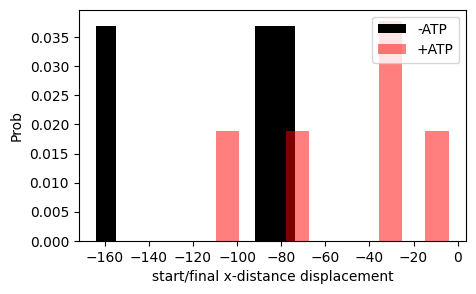

In [56]:
caseName='-ATP'
case = cases[caseName]
plt.hist(case.dists,density=True,color='black',label='-ATP')

caseName='+ATP'
case = cases[caseName]
plt.hist(case.dists,alpha=0.5,density=True,color='red',label='+ATP')
plt.legend(loc=0)
plt.xlabel("start/final x-distance displacement")
plt.ylabel("Prob")


* Tests
```
cd tests
```
* Run (kafka)
```
python3 ../brownian_v3.py -yamlFile expt.yaml -run
```
* Process
```
python3 batchProcess.py -single expt # kant for now
```
* upload expt.csv



In [62]:
sourcePath = "/content/cellmigration/"
simFile = sourcePath+"expt_analysis/expt.csv"
simData = np.loadtxt(simFile)

batchProcess.py    concentration.py	      LICENSE		     README_1.md
brownian_v2.py	   conda_openmm_pytraj.ipynb  master.ipynb	     README.md
brownian_v3.py	   config.bash		      migration_paper.ipynb  run
brownian_v4.py	   cont_analysis	      paper		     states.py
brownian_v5.py	   expt_analysis	      parameters.py	     TAM_example.ipynb
brown_util.py	   expt_analysis.ipynb	      pdb.py		     tests
brown_wnonbond.py  histo.ipynb		      processData.py	     update.py
calculator.py	   lattice.py		      processYaml.py	     validation.py


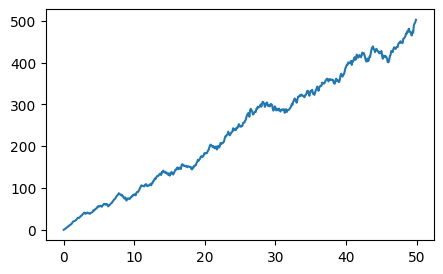

In [63]:
plt.plot(simData[:,0],simData[:,1])

<font color=red>Need to also load sim case where we measure displacements </font>

Not storing D right now until timescale is worked out


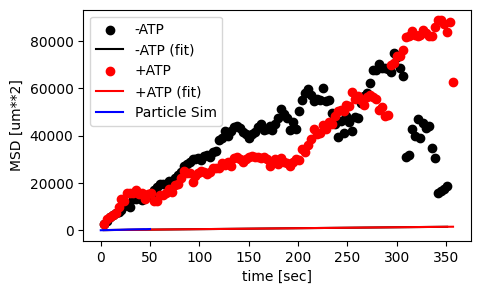

In [68]:
print("Not storing D right now until timescale is worked out")
sec_to_min = 60.
caseName = '-ATP'
case = cases[caseName]
t = case.time1/sec_to_min
plt.scatter(t,case.dataavg1,facecolor='k',label=caseName)
case.D = 1
msd = np.array(t)*4*case.D + 50
plt.plot(t, msd,'k',label=caseName+" (fit)")

caseName = '+ATP'
case = cases[caseName]
t = case.time1/sec_to_min
plt.scatter(t,case.dataavg1,facecolor='r',label=caseName)
case.D = 1
msd = np.array(t)*4*case.D + 50
plt.plot(t, msd,color='r',label=caseName+" (fit)")

# sims
plt.plot(simData[:,0],simData[:,1],color='b',label="Particle Sim")


plt.xlabel("time [min]")
plt.ylabel("MSD [um**2]")
plt.legend(loc=0)
plt.gcf().savefig("msd.png",dpi=300)

In [ ]:
msd[9]

206.09947014256585